<a href="https://colab.research.google.com/github/semenko/liquid-cell-atlas/blob/main/liquid_cell_atlas_shell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Liquid Cell Atlas
**By Nick Semenkovich \<semenko@alum.mit.edu\>**

<br>

A performant, documented approach to the Liquid Cell Atlas (LCA) project. At a high level, we want to develop a signature or "fingerprint" of individual Human cell types using methylation data, and then deconvolute bulk samples.

For example, we can ingest raw (un-annotated) methylation data (e.g. from a peripheral blood draw) and then estimate percentages of cell types observed (e.g. 3% CD4+ T cells), with a focus on exhausted immune cells:

<br>

$f(MethylationData) = \begin{bmatrix}
0.439_{CD4+}\\
0.264_{CD8+}\\
0.170_{Tex}
\end{bmatrix}$

<br>

___


**Training Data**: We train on what limited pure WGBS data exists, predominantly from Blueprint and Encode. We are exploring incorporating RRBS & array data.

$Train = \begin{Bmatrix}
\{WGBS_{ENCODE}, WGBS_{Blueprint}, Array_{Infinium, …} \}_{CD4+}\\
\{WGBS_{ENCODE}, WGBS_{Blueprint}, Array_{Infinium, …} \}_{CD8+}\\
…\\
\end{Bmatrix}$

<br>

**Validation**: Beyond standard held-out data and permutation experiments (see our mansucript), we also validate our model with ground truth experiments of parallel bisulfite/EM-seq data combined with FACS and CyTOF cell-type confirmation.

$Test = \begin{Bmatrix}
\{WGBS, CyTOF, FACS \}_{CD4+}\\
\{WGBS, CyTOF, FACS \}_{CD8+}\\
…\\
\end{Bmatrix}$

<br>

This model is trained only on human data (via Blueprint) but could be trained on mouse or other organisms of interest, if enough WGBS ground-truth data exist.

## Setup / Imports & Helpers

In [4]:
! pip3 -q install plotly pyBigWig pybedtools tensorflow_decision_forests # --upgrade

     |████████████████████████████████| 64 kB 1.2 MB/s 
     |████████████████████████████████| 12.5 MB 8.1 MB/s 
     |████████████████████████████████| 15.8 MB 303 kB/s 
     |████████████████████████████████| 15.1 MB 2.0 MB/s 
     |████████████████████████████████| 511.7 MB 5.9 kB/s 
     |████████████████████████████████| 5.8 MB 43.7 MB/s 
     |████████████████████████████████| 438 kB 49.4 MB/s 
     |████████████████████████████████| 1.6 MB 32.4 MB/s 


In [5]:
import socket
print(f"Running on: {socket.gethostname()}")

# assert socket.gethostname() == "ACLt430"

Running on: 462f8dc3ca8f


In [6]:
import csv
import datetime
import glob
import itertools
import json
import os
import random
import sys
import timeit
import urllib.request

In [7]:
# External libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pyBigWig
import pybedtools
import sklearn.metrics
import sklearn.model_selection
import tensorflow as tf
# import tensorflow_decision_forests as tfdf

from tqdm.notebook import tqdm

import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'colab'

In [8]:
# Run Settings
CHROMOSOMES = ["chr" + str(i) for i in range(1, 23)] + ["chrX"]

# For development, forcably re-run parsing even if a cache exists
IGNORE_CACHE = False

# Parallel processing / multithreading limit
NUM_USABLE_CPUS = len(os.sched_getaffinity(0))

print(f"Usable CPUs: {NUM_USABLE_CPUS}")

Usable CPUs: 2


In [10]:
tf.random.set_seed(2022)
random.seed(2022)

if "google.colab" in sys.modules:
    from google.colab import data_table
    print("Loading pretty datatable formatter.")
    data_table.enable_dataframe_formatter()

# print(f"TFDF Version: {tfdf.__version__}")

Loading pretty datatable formatter.


## Data Loading & Pre-processing

### Blueprint WGBS

Load WGBS data from the Blueprint consortium. There are two file types provided: **cov** and **call**

The **cov** files show any spot covered by our sequening run.

The **call** files show actual CpG methylation calls.

We process these by:
1. Aggregating all **cov** files to find the shared set of regions covered in all samples
2. Filtering these to loci with **>10** reads

In [ ]:
# TODO: Programmatically download these for new / other users? Or bulk store somewhere?
# This directory contains all the .bw coverage and call files from Blueprint
# Source: http://dcc.blueprint-epigenome.eu/#/files
# Files all end with:
#   .CPG_methylation_calls.bs_call.GRCh38.20160531.bw
#                            or
#   .CPG_methylation_calls.bs_cov.GRCh38.20160531.bw

In [ ]:
# Note, files were all generated with bs_call, followed by some filtering, see: http://dcc.blueprint-epigenome.eu/#/md/bs_seq_grch38
# Filters include phred > 20
BLUEPRINT_DATA_PATH = "/home/nsemenkovich/wgbs/blueprint-wgbs-data/raw-methylation-signal"

# Annotations & bs_cov / bs_call names
CELL_TYPE_TO_FILE_ID = {
    "T_CD4_naive": ["S009W451", "S008H151","S007DD51","P580","P582","P584","P586","S007G756"],
    "T_CD4_central_memory": ["S006YC51", "S014QS55"],
    "T_CD4_effector_memory": ["S001U352", "S014QS51"],

    "T_CD8_naive": ["C0066P51","C003VO55","C00256A1bs","S00C2F51"],
    "T_CD8_central_memory": ["C003VO56", "C005UI52"],
    "T_CD8_effector_memory": ["C00256A3bs", "S014WG51"],
    "T_CD8_effector_memory_terminal": ["S002ND51", "S0164R51"],

    "Treg": ["S00XTP51","S001U353"],

    "B_cell_naive": ["S01ECGA1","NBC_NC11_83","NBC_NC11_41","S001JP51","C003K951","S00DM851","C0068L51"],
    "B_cell_memory": ["S017RE51","C003N351"], # Excluding W653; few reads.

    "Plasma_cell": ["S00XCMA1","S00XDKU1","S00XEIU1","G204","G203"],

    "Monocyte": ["S01BHIA1","S01MAPA1","S01E03A1"],
    "Macrophage_M0": ["S001S751","S0039051","S0022I51","S00BHQ51","S00DVR51","C005VG51"],
    "Macrophage_M1": ["S0022I53","S001S753","S0018A52","S00H6O51","S007SK51","S001MJ51"],
    "Macrophage_M2": ["S00BS451","S0062252","S00FTN51","S00C1H51","S00E8W51","S006VI53"],

    "NK_cell": ["C0067N51","S01E8O51","C002CTA1bs","C006G551"],
    "Neutrophil": ["S00K5EA1","C00184A3bs","C001UYA1bs","C0010KA1bs","C004GD51","C0011IA3bs","C000S5A2bs","S00FWHA1","S00K7AA1"],
    "Eosinophil": ["S00V6553","S006XE53"],

    "Dendtritic_immature": ["S00TU2A1", "S00TV0A1"],
    "Dendtritic_mature": ["S00TXXA1", "S00TYVA1"],

    "Megakaryocyte": ["S004AV51", "S004BT51"],
    "Erythroblast": ["S002S351","S002R551"]
}

# Reverse mapping of file id -> cell type
# e.g.  'S01BHIA1': 'Monocyte'
FILE_ID_TO_CELL_TYPE = {sample:cell_type for cell_type, sample_list in CELL_TYPE_TO_FILE_ID.items() for sample in sample_list}

# If the blueprint dict changes, we need to replace our cache files
# This is a tiny checksum of the dictionary state, which we incorporate into
# our cache filenames below.
CELL_TYPE_DICT_SIG = str(hex(abs(hash(json.dumps(CELL_TYPE_TO_FILE_ID, sort_keys=True))))[2:10])
print(f"Dictionary signature for cache files: {CELL_TYPE_DICT_SIG}\n")


BLUEPRINT_FILEKEYS = list(itertools.chain.from_iterable(CELL_TYPE_TO_FILE_ID.values()))

# Validity testing
assert all(len(vals) > 1 for vals in CELL_TYPE_TO_FILE_ID.values()), "We need more than one example per cell type."
assert len(BLUEPRINT_FILEKEYS) == len(set(BLUEPRINT_FILEKEYS)), "One filename is duplicated in the cell types"

print(f"Number of Blueprint cell types: {len(CELL_TYPE_TO_FILE_ID.keys())}")
print(f"Number of Blueprint raw files: {len(BLUEPRINT_FILEKEYS)}")

Dictionary signature for cache files: 61a5661a

Number of Blueprint cell types: 22
Number of Blueprint raw files: 82


#### Create shared **cov** map

Load coverage (if >minimum below) across all files, then determine the set() shared across **all** samples.

IF a locus (e.g. "chr1:123") is missing from **one** single sample, it will be **excluded** from our entire analysis.

IF a locus has \<10 reads in **one** single sample, it will be **excluded** from our entire analysis.

In [ ]:
# The Blueprint cov .bw files include CpGs with trivial coverage, e.g. 1 read.
# Require a minimum of 10 reads per-sample to be considered valid. 
BLUEPRINT_CPG_COV_MINIMUM = 10

RUN_SIGNATURE = f"{BLUEPRINT_CPG_COV_MINIMUM}_{CELL_TYPE_DICT_SIG}"

assert type(BLUEPRINT_CPG_COV_MINIMUM) is int
assert BLUEPRINT_CPG_COV_MINIMUM > 0

print(f"Minimum Blueprint coverage limit: {BLUEPRINT_CPG_COV_MINIMUM}")
print(f" (CpGs with fewer than {BLUEPRINT_CPG_COV_MINIMUM} reads in *any* sample will be ignored.)\n")

# Our output / save file
INTERSECTED_COVERAGE_BED = f"intersected_bs_cov_min_{RUN_SIGNATURE}.bed"

print(f"Coverage BED: {INTERSECTED_COVERAGE_BED}")

if os.path.exists(INTERSECTED_COVERAGE_BED) and not IGNORE_CACHE:
    print("\tPost-processed cov .bed already exists. (Skipping raw Blueprint bs_cov parsing.)")
else:
    print("\t.bed does not exist yet -- parsing bs_cov .bw files. (This will take roughly 30 minutes.)")
    start_time = timeit.default_timer()

    # Dict of CpGs seen across *all* samples in blueprint, at >= BLUEPRINT_CPG_COV_MINIMUM
    #   'chr1': [1234, 1247, ...]
    INTERSECTED_BS_COV_POSITIONS = {}

    ## We loop over all the bs_cov .bw files to build a shared CpG matrix
    for file_key in tqdm(BLUEPRINT_FILEKEYS):
        print(f"{file_key}")
        with pyBigWig.open(BLUEPRINT_DATA_PATH + "/" + file_key + ".CPG_methylation_calls.bs_cov.GRCh38.20160531.bw") as bw_object:
            bw_header = bw_object.header()
            if bw_header['nBasesCovered'] < 1e7 or bw_header['sumData'] < 1e8:
                print('\t\t*** WARNING: Input .bw has few reads or low coverage. This may cause unexpected results, consider removing this file.')
                print(f"\t\tnBasesCovered: {bw_header['nBasesCovered']}, sumData: {bw_header['sumData']}")
            for chrom in CHROMOSOMES:
                # Get existing values, or set to the current ones

                # For ease, we require a CpG to be covered at least BLUEPRINT_CPG_COV_MINIMUM across all cell
                # types to be considered  for our fingerprints, though we could leave NaN values if needed,
                # as decision trees, etc. can handle those gracefully.
                current_loop_values = set([start for start, _, cov in bw_object.intervals(chrom) if cov >= BLUEPRINT_CPG_COV_MINIMUM])
                existing_values = INTERSECTED_BS_COV_POSITIONS.get(chrom, current_loop_values)

                # For the first time we see a chrom, we'll intersect ourselves
                INTERSECTED_BS_COV_POSITIONS[chrom] = existing_values.intersection(current_loop_values)


    # Save this hard work as a .bed for later recovery if needed
    with open(INTERSECTED_COVERAGE_BED, 'w') as outfile:
        # A .bed is just a .tsv with ['chrom', 'chromStart', 'chromEnd']
        bed_writer = csv.writer(outfile, delimiter='\t')
        for chr in CHROMOSOMES:
            for entry in INTERSECTED_BS_COV_POSITIONS[chr]:
                bed_writer.writerow([chr, entry, entry+1])

    # del INTERSECTED_BS_COV_POSITIONS
    print(f"\nWrote data to: {INTERSECTED_COVERAGE_BED}") # Unsorted
    print(f"Elapsed time: {datetime.timedelta(seconds=timeit.default_timer() - start_time)}")


Minimum Blueprint coverage limit: 10
 (CpGs with fewer than 10 reads in *any* sample will be ignored.)

Coverage BED: intersected_bs_cov_min_10_61a5661a.bed
	.bed does not exist yet -- parsing bs_cov .bw files. (This will take roughly 20 minutes.)


  0%|          | 0/82 [00:00<?, ?it/s]

S009W451
S008H151
S007DD51
P580
P582
P584
P586
S007G756
S006YC51
S014QS55
S001U352
S014QS51
C0066P51
C003VO55
C00256A1bs
S00C2F51
C003VO56
C005UI52
C00256A3bs
S014WG51
S002ND51
S0164R51
S00XTP51
S001U353
S01ECGA1
NBC_NC11_83
NBC_NC11_41
S001JP51
C003K951
S00DM851
C0068L51
S017RE51
C003N351
S00XCMA1
S00XDKU1
S00XEIU1
G204
G203
S01BHIA1
S01MAPA1
S01E03A1
S001S751
S0039051
S0022I51
S00BHQ51
S00DVR51
C005VG51
S0022I53
S001S753
S0018A52
S00H6O51
S007SK51
S001MJ51
S00BS451
S0062252
S00FTN51
S00C1H51
S00E8W51
S006VI53
C0067N51
S01E8O51
C002CTA1bs
C006G551
S00K5EA1
C00184A3bs
C001UYA1bs
C0010KA1bs
C004GD51
C0011IA3bs
C000S5A2bs
S00FWHA1
S00K7AA1
S00V6553
S006XE53
S00TU2A1
S00TV0A1
S00TXXA1
S00TYVA1
S004AV51
S004BT51
S002S351
S002R551

Wrote data to: intersected_bs_cov_min_10_61a5661a.bed
Elapsed time: 0:26:25.167258


#### Filter from Encode DAC Exclusion List

Encode defines a standard list of "bad" regions -- very low complexity / information content, etc. that show up in some studies but are not informative. We remove them and do some other standard data cleaning.

In [ ]:
# Load the .bed from above
raw_bs_cov_bed = pybedtools.BedTool(INTERSECTED_COVERAGE_BED)
print(f"Number of entries in bs_cov (raw): {len(raw_bs_cov_bed):,}")

# Remove the ENCODE DAC Exclusion List Regions
# Via https://www.encodeproject.org/annotations/ENCSR636HFF/
# Specifically: https://www.encodeproject.org/files/ENCFF356LFX/

if not os.path.exists("ENCFF356LFX.bed.gz"):
    print("Downloading ENCODE DAC Exclusion List")
    urllib.request.urlretrieve("https://www.encodeproject.org/files/ENCFF356LFX/@@download/ENCFF356LFX.bed.gz", "ENCFF356LFX.bed.gz")

excluded_regions = pybedtools.BedTool("ENCFF356LFX.bed.gz")
print(f"Number of entries in excluded_regions: {len(excluded_regions):,}")
assert len(excluded_regions) > 900 # 910 as of 1/2022

# .saveas forces this to render, otherwise may be a generator
# TODO: Fix path to be more specific
cleaned_sorted_bs_cov = raw_bs_cov_bed.subtract(excluded_regions).sort().saveas('bs_cov_cleaned_sorted.bed')
print(f"Number of remaining bs_cov entries: {len(cleaned_sorted_bs_cov):,}")
assert len(cleaned_sorted_bs_cov) > 90000 # We expect about 90k entries


# Convert `bs_cov_cleaned_sorted` to a dict too:
#  key: chr
#  val: [sorted list of bs_cov positions]
# NOTE: This works because dicts are insertion ordered as of Python>3.7
BS_COV_POSITIONS = {}
for bed_entry in cleaned_sorted_bs_cov:
    BS_COV_POSITIONS.setdefault(bed_entry.chrom, []).append(bed_entry.start)

Number of entries in bs_cov (raw): 93,284
Number of entries in excluded_regions: 910
Number of remaining bs_cov entries: 91,124


#### Load bs_call data

Now switch to methylation **calls** -- we only load calls that are within the shared coverage CpGs defined above.

The Blueprint project generated these calls using https://github.com/heathsc/bs_call, see details: http://dcc.blueprint-epigenome.eu/#/md/bs_seq_grch38


In [ ]:
# NOTE: Blueprint also has some high/low methylation calls, aggregated into clusters, e.g.:
#       `P579.hyper_meth.bs_call.GRCh38.20150707.bed.gz`
#       Those files contain nearest gene annotations, region-wide scores, etc.
#       We don't use them here and prefer raw individual CpGs.

# Store cpg_call values for all 
# Dict of:
#  key: file_id (e.g. "S009W451")
#  val: dict of chr->list of bs_call ints
#     e.g. "chr1": [1, 4, 1, 0, 12 …]
FILE_ID_TO_CPG_CALLS = { }

# cache_file = "bs_call_min_" + str(BLUEPRINT_CPG_COV_MINIMUM) + ".json"
print("Parsing bs_call files. [This should take ~10 minutes.]")
for file_key in tqdm(BLUEPRINT_FILEKEYS):
    print(f"{file_key}")
    FILE_ID_TO_CPG_CALLS[file_key] = {}
    with pyBigWig.open(BLUEPRINT_DATA_PATH + "/" + file_key + ".CPG_methylation_calls.bs_call.GRCh38.20160531.bw") as bw_object:
        for chrom in CHROMOSOMES:
            # This is more nuanced than the bs_cov data, since we only want to look at the 
            # CpGs that were covered across all samples. (The intervals now in BS_COV_POSITIONS).

            # Grabbing the entire chr interval is super slow
            # FILE_ID_TO_CPG_CALLS[file_key][chrom] = [i for pos, _, i in bw_object.intervals(chrom) if pos in shared_pos_for_this_chromosome]
            
            # Each .bw interval is a nested tuple of: ((start, end, value))
            # We extract all the values that overlap our bs_cov set.
            FILE_ID_TO_CPG_CALLS[file_key][chrom] = [bw_object.intervals(chrom, pos, pos+1)[0][2] for pos in BS_COV_POSITIONS[chrom]]


Parsing bs_call files. [This should take ~5 minutes.]


  0%|          | 0/82 [00:00<?, ?it/s]

S009W451
S008H151
S007DD51
P580
P582
P584
P586
S007G756
S006YC51
S014QS55
S001U352
S014QS51
C0066P51
C003VO55
C00256A1bs
S00C2F51
C003VO56
C005UI52
C00256A3bs
S014WG51
S002ND51
S0164R51
S00XTP51
S001U353
S01ECGA1
NBC_NC11_83
NBC_NC11_41
S001JP51
C003K951
S00DM851
C0068L51
S017RE51
C003N351
S00XCMA1
S00XDKU1
S00XEIU1
G204
G203
S01BHIA1
S01MAPA1
S01E03A1
S001S751
S0039051
S0022I51
S00BHQ51
S00DVR51
C005VG51
S0022I53
S001S753
S0018A52
S00H6O51
S007SK51
S001MJ51
S00BS451
S0062252
S00FTN51
S00C1H51
S00E8W51
S006VI53
C0067N51
S01E8O51
C002CTA1bs
C006G551
S00K5EA1
C00184A3bs
C001UYA1bs
C0010KA1bs
C004GD51
C0011IA3bs
C000S5A2bs
S00FWHA1
S00K7AA1
S00V6553
S006XE53
S00TU2A1
S00TV0A1
S00TXXA1
S00TYVA1
S004AV51
S004BT51
S002S351
S002R551


## Export as a TF-parseable .csv

So this is a little wild -- we can just directly load these into TF, but if we make them into a jumbo CSV, we can get more reproducibility, and can easily move the model around.

We export a **ludicrous** CSV like:

```
sampleid, celltype, chr1:123, chr1:234, ...
S00K5EA1, Neutrophil, 4, 0, ...
```

The dimensions here will be roughly 90,000 x 83. [CPGs x Samples]

In [ ]:
TF_CSV_EXPORT_FILE = f"tf_train_data_{RUN_SIGNATURE}.csv"

if os.path.isfile(TF_CSV_EXPORT_FILE):
    print(f"Writing Blueprint data to a .csv for TensorFlow: {TF_CSV_EXPORT_FILE}")
    with open(TF_CSV_EXPORT_FILE, 'w', newline='') as csvfile:
        tf_csv_writer = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_NONE)

        # Write an enormous header including all BS_COV_POSITIONS as "chr1:123"
        tf_csv_writer.writerow(['sample', 'celltype'] +
                               [f"{chrom}:{start_pos}" for chrom, chrom_pos_list in BS_COV_POSITIONS.items() for start_pos in chrom_pos_list])
        
        # Loop over all our file bs_call entries and write
        for file_id, file_cov_dict in tqdm(FILE_ID_TO_CPG_CALLS.items()):
            tf_csv_writer.writerow([file_id, FILE_ID_TO_CELL_TYPE[file_id]] + 
                                    [start_pos for chrom, chrom_pos_list in file_cov_dict.items() for start_pos in chrom_pos_list])


Writing Blueprint data to a .csv for TensorFlow: tf_train_data_10_61a5661a.csv


  0%|          | 0/82 [00:00<?, ?it/s]

In [ ]:
# experiument with loading this

tfds = tf.data.experimental.make_csv_dataset(TF_CSV_EXPORT_FILE,
                                             batch_size=128,
                                             label_name="celltype",
                                             # Skip the first sampleid column
                                             select_columns=range(1,len(cleaned_sorted_bs_cov)+2))

2022-04-12 14:28:30.966357: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
for data, labels in tfds:
    print("here!")
    print(labels)
    print(data.shape)

2022-04-13 13:03:29.721943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-04-13 13:03:29.806389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2 of 10000
2022-04-13 13:03:29.890336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 3 of 10000
2022-04-13 13:03:29.970733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4 of 10000
2022-04-13 13:03:30.050091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 5 of 10000
2022-04-13 13:03:30.131031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 6 of 10000
2022-04-13 13:03:30.210359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer 

here!
tf.Tensor(
[b'T_CD4_effector_memory' b'Neutrophil' b'T_CD4_naive' b'Macrophage_M0'
 b'Erythroblast' b'Macrophage_M2' b'Macrophage_M1' b'NK_cell'
 b'B_cell_naive' b'T_CD4_central_memory' b'Macrophage_M0' b'B_cell_naive'
 b'Dendtritic_immature' b'Treg' b'Macrophage_M0' b'Eosinophil'
 b'T_CD8_central_memory' b'B_cell_memory' b'Neutrophil' b'Plasma_cell'
 b'Monocyte' b'Macrophage_M2' b'T_CD4_central_memory' b'Macrophage_M2'
 b'Neutrophil' b'T_CD4_naive' b'T_CD8_effector_memory' b'Neutrophil'
 b'Plasma_cell' b'T_CD8_naive' b'T_CD8_effector_memory_terminal'
 b'NK_cell' b'Neutrophil' b'Macrophage_M2' b'Macrophage_M1'
 b'Macrophage_M2' b'Neutrophil' b'Neutrophil' b'B_cell_naive'
 b'Neutrophil' b'T_CD4_naive' b'Dendtritic_immature' b'NK_cell'
 b'B_cell_naive' b'Neutrophil' b'Treg' b'T_CD8_naive' b'B_cell_naive'
 b'B_cell_naive' b'Erythroblast' b'Monocyte' b'T_CD4_naive'
 b'B_cell_memory' b'Dendtritic_mature' b'Macrophage_M1' b'Plasma_cell'
 b'Macrophage_M2' b'T_CD4_effector_memory' b'Eosi

AttributeError: ignored

### Encode Data

Encode has tissue-level data, but less immune cell data. (e.g. it contains liver, thyroid, etc., but no CD4+ T cells).

In [ ]:
# Encode 117 human WGBS samples, and more from RRBS -- however they are esentially all whole tissues (e.g. "liver")
# We can consider building a mixed model later; for now, we want only specific cells.


### DEEP Data

Part of a gGerman consortium: https://deep.dkfz.de/#/experiments

This has a handful of immunologic lineages, along with mixed tissue similar to Encode.

In [ ]:
# https://deep.dkfz.de/#/experiments

### RNBeads

A post-processing of multiple data sources, useful aggregation: https://rnbeads.org/methylomes.html

### Array Data

Infinium array methylation data

In [ ]:
# Should we bulk download these?

## Compute cell fingerprints -- Individual CpG approach

At this point we have a ton of CpGs (~300,000) across our samples. From Blueprint, each has a value stored as a float, from 0.0-1.0 reflecting % methylation.

This is now a multi-class classification problem (i.e. each cell belongs to **exactly** one of multiple classes) -- though we can implement it more flexibly as a multi-label classifier (i.e. each cell may belong to multiple classes, with different probability). 

For example, a true CD4+ T cell might get assigned `p(CD4) = 0.9` and `p(CD8) = 0.6`, and hopefully low probabilities for less related cell types, e.g. `p(Mφ) = 0.2`.

We can try to model this with Tensorflow or scikit-learn, among other packages. Let's see how those perform.

**Note**: These ignore methylation co-occurrence data -- i.e. two or more CpGs methylated on the same read --  which can't be obtained from the bs_call data, only raw .bam data.


### Subset Blueprint Data

We have a huge imbalance in our data; very few labels (cell types), but >300,000 CpGs. we can try to reduce our CpG list further to those likely to be the most informative.

One option (not implemented here), is to limit CpGs based on genomic position -- exon / intron / within NN bp of start/stop, etc.

We can also threshold the CpGs to require a minimum coverage.



### Perform multi-label classification (individual CpG only)

#### WIP CODE Define a test/train split

In [ ]:
# TODO: Remove / archive this code? Splitting separately in sckit-learn/TensorFlow, below.

### Establish a test/train split on these (limited) data.
# Below, we can also compare to Encode and internal data.
TEST_TRAIN_SPLIT = 0.25  # Hold out 25% of each cell type's files as a test set.

CELL_TYPE_TO_FILE_ID_TRAIN = {}
CELL_TYPE_TO_FILE_ID_TEST = {}

for cell_type, cell_files in CELL_TYPE_TO_FILE_ID.items():
    # Take a minimum of 1 item, regardless of % above.
    CELL_TYPE_TO_FILE_ID_TEST[cell_type] = random.sample(cell_files, max(1, round(len(cell_files) * TEST_TRAIN_SPLIT)))
    CELL_TYPE_TO_FILE_ID_TRAIN[cell_type] = [x for x in cell_files if x not in CELL_TYPE_TO_FILE_ID_TEST[cell_type]]

In [ ]:
train_test_stats_df = pd.DataFrame(list(
    zip(
        CELL_TYPE_TO_FILE_ID.keys(),
        [len(e) for e in CELL_TYPE_TO_FILE_ID.values()], 
        [len(e) for e in CELL_TYPE_TO_FILE_ID_TRAIN.values()],
        [len(e) for e in CELL_TYPE_TO_FILE_ID_TEST.values()]
        )
    ),
    columns = ["Cell", "Total", "Train", "Test"])

train_test_stats_df

,Cell,Total,Train,Test
0,CD4,8,6,2
1,CD8,4,3,1
2,Treg,2,1,1
3,B_cell_naive,7,5,2
4,B_cell_memory,2,1,1
5,Plasma_cell,5,4,1
6,Monocyte,3,2,1
7,Macrophage_M0,6,4,2
8,Macrophage_M1,6,4,2
9,Macrophage_M2,6,4,2


In [ ]:
fig = px.bar(
        train_test_stats_df,
        x="Cell", y="Total", color="Test", text_auto=True,
        title="Amount of Blueprint WGBS Test/Train Data (# of BAM files) per Cell Type"
)
fig.update_layout(autosize=False, width=800)
fig.show()

##### Define a TensorFlow Decision Forests GBDT Mdel

In [ ]:
## Establish our TensorFlow Model
# List available models
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [ ]:
# Existing hyperparameters for our chosen model
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


In [ ]:
## First let's format data for TensorFlow

# We can create a tensor directly, but it's more flexible to manipulate things in a Pandas dataframe.
temp_array_for_df = []

for k, v in CELL_TYPE_TO_FILE_ID.items():
    for file_id in v:
        working = [k]
        # TODO: Expand beyond Chr1
        # Expand this, which is a nest per-chromosome list
        working.extend(FILE_ID_TO_CPG_CALLS[file_id]['chr1']) # [val for chrom in FILE_ID_TO_CPG_CALLS[file_id] for val in chrom]
        temp_array_for_df.append(working)

per_cpg_df = pd.DataFrame(temp_array_for_df)

# TODO: Rename columns to actual cpg loci
per_cpg_df.rename(columns={0: 'CellType'}, inplace=True)
# A bit of a hack: int->string, as tfdf seems to require iterable column names (to check if they're valid, oddly). 
per_cpg_df.columns = [str(x) for x in per_cpg_df.columns]

In [ ]:
# Let's train a classification model on this label:
CLASSIFICATION_LABEL = "CellType"

# NOTE: Classification labels must be integers.
classes = sorted(per_cpg_df[CLASSIFICATION_LABEL].unique().tolist())
print(f"Label classes for: {CLASSIFICATION_LABEL} = {classes}\n")

classification_model_data = per_cpg_df.copy()
classification_model_data[CLASSIFICATION_LABEL] = classification_model_data[CLASSIFICATION_LABEL].map(classes.index)
print(f"Input data shape: {classification_model_data.shape}")

Label classes for: CellType = ['B_cell_memory', 'B_cell_naive', 'CD4', 'CD8', 'Eosinophil', 'Erythroblast', 'Macrophage_M0', 'Macrophage_M1', 'Macrophage_M2', 'Monocyte', 'NK_cell', 'Neutrophil', 'Plasma_cell', 'Treg']

Input data shape: (66, 7809)


In [ ]:
# Split into test/train datasets and labels, with equal percentages of each cell type.
# Note: We join the labels back into the dataset below, as that works a little better with tfdf.
cpg_train_ds, cpg_test_ds, label_train_ds, label_test_ds = sklearn.model_selection.train_test_split(classification_model_data.drop(['CellType'], axis=1),
                                                                                        classification_model_data['CellType'],
                                                                                        test_size=0.2,
                                                                                        random_state=2022,
                                                                                        stratify=classification_model_data['CellType']) # Force equal % of class labels.

print(f"Training data shape: {cpg_train_ds.shape}")
print(f"Testing data shape: {cpg_test_ds.shape}")

# Add the labels back into the data; this works more cleanly with tfdf.
training_df = pd.concat([label_train_ds, cpg_train_ds], axis=1)
testing_df = pd.concat([label_test_ds, cpg_test_ds], axis=1)

assert not training_df.isnull().values.any()
assert not testing_df.isnull().values.any()

print("Converting Pandas data to TensorFlow dataset...")
training_classification_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(training_df, label=CLASSIFICATION_LABEL,
                                                                      task=tfdf.keras.Task.CLASSIFICATION, fix_feature_names=False)

testing_classification_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(testing_df, label=CLASSIFICATION_LABEL,
                                                                     task=tfdf.keras.Task.CLASSIFICATION, fix_feature_names=False)

Training data shape: (52, 7808)
Testing data shape: (14, 7808)
Converting Pandas data to TensorFlow dataset...


/home/nsemenkovich/.local/miniconda3/envs/jupyter/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2038: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/home/nsemenkovich/.local/miniconda3/envs/jupyter/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2038: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [ ]:
print(f"Training GradientBoostedTrees classification model on: {CLASSIFICATION_LABEL}")

gbt_classification_model = tfdf.keras.GradientBoostedTreesModel(
    num_threads=NUM_USABLE_CPUS,
    task=tfdf.keras.Task.CLASSIFICATION,
    hyperparameter_template="benchmark_rank1"
    )

gbt_classification_model.compile(metrics=["accuracy"])

gbt_classification_model.fit(training_classification_ds_tf, verbose=2)

Training GradientBoostedTrees classification model on: CellType
Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpfkylzgl2 as temporary training directory
Starting reading the dataset
Training tensor examples:
Features: {'1': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, '2': <tf.Tensor 'data_1111:0' shape=(None,) dtype=float64>, '3': <tf.Tensor 'data_2222:0' shape=(None,) dtype=float64>, '4': <tf.Tensor 'data_3333:0' shape=(None,) dtype=float64>, '5': <tf.Tensor 'data_4444:0' shape=(None,) dtype=float64>, '6': <tf.Tensor 'data_5555:0' shape=(None,) dtype=float64>, '7': <tf.Tensor 'data_6666:0' shape=(None,) dtype=float64>, '8': <tf.Tensor 'data_7586:0' shape=(None,) dtype=float64>, '9': <tf.Tensor 'data_7697:0' shape=(None,) dtype=float64>, '10

Streaming output truncated to the last 5000 lines.
features: "3593"
features: "3594"
features: "3595"
features: "3596"
features: "3597"
features: "3598"
features: "3599"
features: "36"
features: "360"
features: "3600"
features: "3601"
features: "3602"
features: "3603"
features: "3604"
features: "3605"
features: "3606"
features: "3607"
features: "3608"
features: "3609"
features: "361"
features: "3610"
features: "3611"
features: "3612"
features: "3613"
features: "3614"
features: "3615"
features: "3616"
features: "3617"
features: "3618"
features: "3619"
features: "362"
features: "3620"
features: "3621"
features: "3622"
features: "3623"
features: "3624"
features: "3625"
features: "3626"
features: "3627"
features: "3628"
features: "3629"
features: "363"
features: "3630"
features: "3631"
features: "3632"
features: "3633"
features: "3634"
features: "3635"
features: "3636"
features: "3637"
features: "3638"
features: "3639"
features: "364"
features: "3640"
features: "3641"
features: "3642"
feat

In [ ]:
# NOTE: There was internal validation above with some percent of the dataset.
gbt_classification_evaluation = gbt_classification_model.evaluate(testing_classification_ds_tf, return_dict=True)
print()

for name, value in gbt_classification_evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 30s 30s/step - loss: 0.0000e+00 - accuracy: 0.5714

loss: 0.0000
accuracy: 0.5714


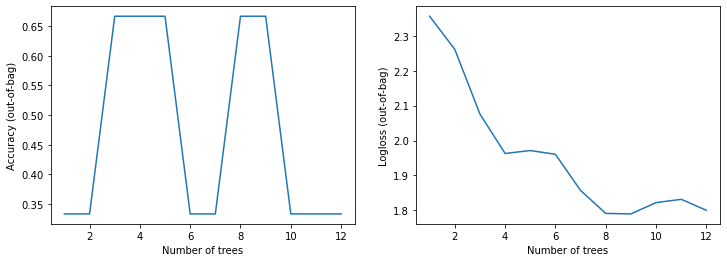

In [ ]:
logs = gbt_classification_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

#### WIP Code for sklearn

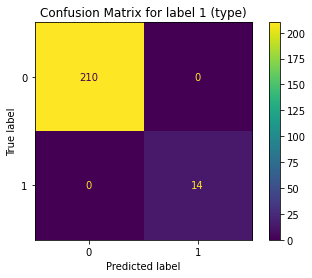

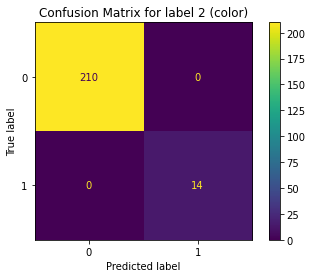

In [ ]:
# First do some data cleaning for TensorFlow

CELL_LABELS = list(CELL_TYPE_TO_FILE_ID.keys())

# TODO: Is there a cleaner approach here?

# Make one-hot encoded training labels, e.g. [0,0,1,0,0,...]
binarizer = sklearn.preprocessing.LabelBinarizer()
labels_binarized = binarizer.fit_transform(CELL_LABELS)
CELL_LABELS_ENCODED = dict(zip(CELL_LABELS, labels_binarized.tolist()))

training_data = []
training_labels = []
testing_data = []
testing_labels = []

for cell_type in CELL_LABELS:
    for k, v in CELL_TYPE_TO_FILE_ID_TRAIN.items():
        for file_id in v:
            training_labels.append(CELL_LABELS_ENCODED[k])
            training_data.append(FILE_ID_TO_CPG_CALLS[file_id]['chr1'])

    for k, v in CELL_TYPE_TO_FILE_ID_TEST.items():
        for file_id in v:
            testing_labels.append(CELL_LABELS_ENCODED[k])
            testing_data.append(FILE_ID_TO_CPG_CALLS[file_id]['chr1'])



svm = sklearn.svm.LinearSVC(random_state=42)
multiclass_classifier = sklearn.multiclass.OneVsRestClassifier(svm, n_jobs=-1) # -1 specifies all threads

# multilabel_classifier = sklearn.multioutput.MultiOutputClassifier(svm, n_jobs=-1) # -1 specifies all threads

# Fit our data
multiclass_classifier = multiclass_classifier.fit(training_data, training_labels)
# multilabel_classifier = multilabel_classifier.fit(training_data, training_labels)

# Get predictions on test data
testing_preds = multiclass_classifier.predict(testing_data)
# testing_preds = multilabel_classifier.predict(testing_data)

# Confusion matricies (how'd we do?)
matrices = sklearn.metrics.multilabel_confusion_matrix(testing_labels, testing_preds)
confusion_matrix(testing_labels, testing_preds))

# Plotting matrices: code
cmd = sklearn.metrics.ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(testing_labels)).plot()
plt.title('Confusion Matrix for label 1 (type)')
plt.show()
cmd = sklearn.metrics.ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(testing_labels)).plot()
plt.title('Confusion Matrix for label 2 (color)')
plt.show()

## Evaluate per-cell type fingerprints (individual CpG only)

Since there are so few samples available, evaluation is hard. We can hold out samples for testing, but then we can't train much data. We can train on all data, but then we can't easily tell if we're overfit.

One option for an independent test dataset is an in-house defined mixture of WGBS data. Abul performed a mixture of defined cell types in known proportions, which underwent WGBS. Raw .bam files stored here:
`/home/ialahi/ialahi_ris/RIS/Active/work/analysis/AllBlueprintBamTogether/Healthy-PBMC-WGBS_bam`

Note that we also called DMRs 

In [ ]:
# 

#### Perform gradient-boosted tree multi-label classification (individual CpG only)

In [ ]:
# TODO: Implement GBT, likely from Yggdrasil for TF

## Compute Fingerprints -- Read-Level Approach

The above multi-label classifier ignores methylation co-occurrence data. That's because the bs_call data loses some of the information content from the raw reads.

Let's take, for example, two cell types ("Cell A", "Cell B"), with only two CpGs. One can imagine linked methylation states that would be lost in bs_call data.

Cell Type | CpG 1 | CpG 2
-- | -- | -- 
Cell A | X | O
Cell A | O | X
Cell B | X | X
Cell B | O | O
**bs_call % methylation** | **0.5** | **0.5**

In this example, Cell A's CpGs are mutually exclusive. Whereas in Cell B, they are both on or off. One can imagine these (or even more complex states) that may reflect different subtypes or states of a given cell.

To train a read counting model, need to determine information content/clustering on a per-read basis. We can build a model of per-read information one of two ways:

1. From a fingerprint matrix of individual reads (above) or,
2. Training on raw reads themselves

In approach #1, we can assign a delta score to every individual CpG. Then for each read, we can compute a composite delta score. Unfortunately, this ignores co-occurrence data (two or more CpGs within the same read) -- but if we assume CpGs appear in clusters, we may incidentally capture some co-occurrence.

In approach #2, we train on co-occurence data itself -- that is, train on the individual .bam files.

We can do this via a sliding window across all potential CpGs. Let's define a sliding window (a vector, or rank-1 tensor) equal to the maximum read size, e.g. 150bp. We can then store three states: -1 (not a CpG), 0 (unmethylated), and 1 (methylated). 

e.g. [-1 -1 -1 0 -1 -1 1] = 150 bits (max bp of a read)

We can then build these vectors per-sample class, and store them as a tensor, for input to multi-label classification in TensorFlow.

### Visualize Performance

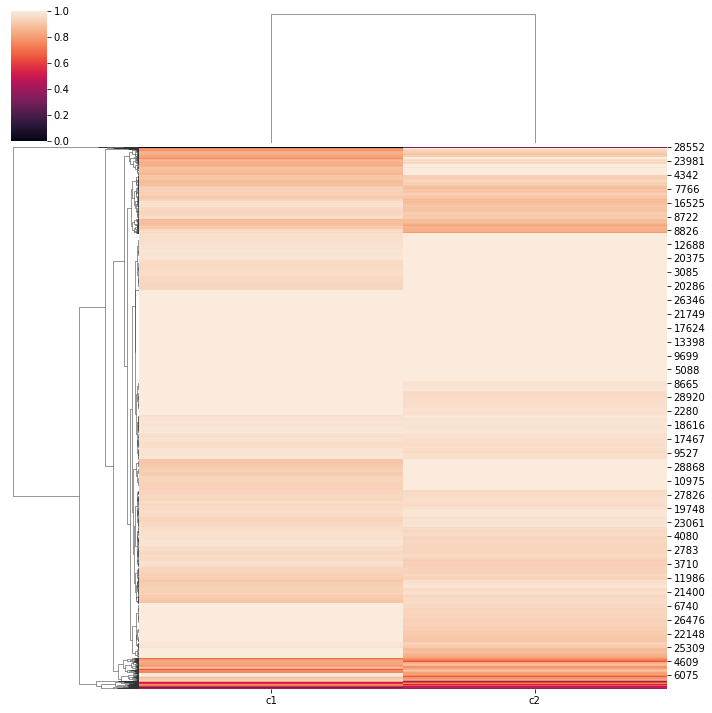

In [ ]:
# Sample hierarhical clutering between 2 cell types's CpG on Chr1
import sys
sys.setrecursionlimit(100000) # Ugly hack
import pandas as pd
import seaborn as sns
d = {'c1': FILE_ID_TO_CPG_CALLS['S009W451']['chr1'], 
     'c2': FILE_ID_TO_CPG_CALLS['S008H151']['chr1']}
df = pd.DataFrame(d)
sns.clustermap(df)

## Evaluation on Array Data

Lots of data exist from array platforms (e.g. Illumina's Infinium MethylationEPIC). How do we perform using those data?

We can use a matrix to call those, but largely have undefined data (no read level of course) for TensorFlow.

We could make two modes for our model; one of CpG-only (no read-level) fingerprints (presumably less accurate), and one of read-level modeling.

**TODO: Can we train on array data?**

### Array vs Blueprint CpG Coverage

High level statistics on overlapping CpGs and coverage differences.

In [ ]:
# How do the CpGs covered by Blueprint compare to 40k and Infinium arrays?

## Naïve Fingerprints

Here, we assign each cell a simple fingerprint, treating each CpG as independent.

| Cell Type | CpG-0 | CpG-1 | ... | CpG-N |
| - | - | - | - | - |
| CD4+ T cell | O | X | … | … |
| CD8+ T cell | X | O | … | … |

We then train a gradient boosted decision tree on all available CpG data.

## Per-fragment Fingerprints 

Here, we assign each cell a fingerprint based not on individual CpGs, but their co-occurrence within a given read from a raw .bam file.

This preserves some state data. e.g. if CpG 1 and CpG 2 are in the same raw read, we note their states, e.g. [0 1].

| Cell Type | [ CpG-0  CpG-1 ] | [ CpG-1  CpG-2 ] | … | 
| - | - | - | - |
| CD4+ T cell | O | X | … |
| CD8+ T cell | X | O | … |

Note that we treat this as a ~150 BP rolling window across all possible positions in a 150 BP read (e.g. in a theoretical window of 150 BP, maybe we have 150 GC sites].

TODO: Prune this aggressively to the max number of true called CpGs.


## Validation with CyTOF & Internal Truth


In [ ]:
# PBMC Ground Truth Internal Data:

CELL_TYPES = ['T_CD4_naive', 'T_CD4_central_memory', 'T_CD4_effector_memory', 'T_CD8_naive', 'T_CD8_central_memory', 'T_CD8_effector_memory', 'T_CD8_effector_memory_terminal', 'Treg', 'NK_Cell', 'B_Cell_naive', 'B_Cell_memory', 'Plasma_Cell', 'Monocyte', 'Dendritic']
CELL_TYPES_DOTS = [i.replace('_', '.') for i in CELL_TYPES]

## PBMC Mixture --> Ground Truth Percentages
# This maps sample ID to cell type percentage.
PBMC_MIXTURE_TRUTH_BY_CYTOF = {
    '03': [11.42,9.7,9.5,8.9,1.9,8.9,5.4,0.29,8.3,5.92,1.86,0.02,7.54,1.8],
    '14': [7.83,7,6.9,9.96,1.2,10.3,2.8,0.14,12.7,8.44,2.05,0.01,6.65,1.3],
    '24': [15.1,12.2,14.6,8.63,1,7.2,4.5,0.5,7.08,4.92,1.82,0.05,4.12,1.22],
    '31': [10.8,6.9,9.9,8.4,0.8,7.3,4.9,0.12,14.96,5.58,1.99,0.01,5.13,1.25],
    '49': [9.84,8.4,16.6,10.8,1.2,8.2,4.5,0.19,5.49,7.64,2.00,0.01,7.63,1.12],
    '50': [6.2,4.3,5.9,4.04,0.9,3.5,1.8,0.27,9.43,5.66,1.21,0.13,7.14,1.75],
    '51': [10.4,6.1,7.1,5.2,0.4,3,2.1,0.18,14.17,6.50,4.39,0.02,10.5,1.65],
}

# Using "Second Flow" in Abul's. spreadsheet
PBMC_MIXTURE_TRUTH_BY_FLOW_SECOND = {
    '03': [11.55,6.910,7.244,21.07,None,None,None,0.34,4.45,5.70,2.36,None,6.31,1.16],
    '14': [8.56,6.504,3.649,19.89,None,None,None,0.22,5.15,7.23,5.29,None,5.78,0.81],
    '24': [24.75,9.305,5.088,14.26,None,None,None,0.44,5.02,4.76,1.99,None,5.02,1.12],
    '31': [13.5,6.967,4.343,14.77,None,None,None,0.18,4.98,2.23,0.97,None,3.22,0.88],
    '49': [13.68,7.324,8.396,21.25,None,None,None,0.16,3.9,6.73,3.27,None,8.8,0.5],
    '50': [8.56,5.823,2.675,6.12,None,None,None,0.22,6.14,5.76,1.25,None,15.9,0.83],
    '51': [10.61,5.612,3.489,9.11,None,None,None,0.21,10.12,3.83,3.55,None,10.21,1.02],
}

# Using "First Flow" in Abul's. spreadsheet
# One flow experiment with missing samples and no corresponding CyTOF
PBMC_MIXTURE_TRUTH_BY_FLOW_FIRST = {
    '03': [13.95,10.146,4.844,24.16,None,None,None,0.28,6.2,5.25,2.29,None,5.43,0.69],
    '14': [11.51,8.508,3.232,23.85,None,None,None,0.12,11.99,4.73,4.29,None,4.94,0.44],
    '31': [15.48,8.244,3.624,23.93,None,None,None,0.11,14.17,5.58,2.94,None,7.77,0.35],
    '49': [12.74,8.389,6.605,23.95,None,None,None,0.19,3.74,6.96,3.06,None,6.39,0.34],
    '50': [14.53,7.674,1.654,10.83,None,None,None,0.14,6.16,8.99,2.14,None,22.45,0.52],
}

assert all([len(e) == len(CELL_TYPES) for e in PBMC_MIXTURE_TRUTH_BY_CYTOF.values()])
assert all([len(e) == len(CELL_TYPES) for e in PBMC_MIXTURE_TRUTH_BY_FLOW_SECOND.values()])
assert all([len(e) == len(CELL_TYPES) for e in PBMC_MIXTURE_TRUTH_BY_FLOW_FIRST.values()])

# Nested dicts, so you can run:
#  PBMC_TRUTH_DICT_FLOW['03']['Treg']
PBMC_TRUTH_DICT_FLOW = {k:dict.fromkeys(CELL_TYPES_DOTS, v) for k,v in PBMC_MIXTURE_TRUTH_BY_FLOW}
PBMC_TRUTH_DICT_CYTOF = {k:dict.fromkeys(CELL_TYPES_DOTS, v) for k,v in PBMC_MIXTURE_TRUTH_BY_CYTOF}

## Attic: Rewrite of Irfan's Pure Fragment Counting Approach

In [ ]:
QUALITY_THRESHOLD=40

### Get our processing files

## Raw .BAM file (~100 MB)
# Original source: /Users/irffanalahi/Research/Research_code/gitignorefolder/MHB_per_read/softreadcounting/testtheidea/veryefficient/CD4allrange_NR_1000000_insilmix41_sorted
! wget --no-config -q --no-clobber -O CD4allrange_NR_1000000_insilmix41_sorted https://wustl.box.com/shared/static/0lil5uevu1vxid2z3bvr8tvehvxwa7ha
bam_file = "CD4allrange_NR_1000000_insilmix41_sorted"
# Index, too
! wget --no-config -q --no-clobber -O CD4allrange_NR_1000000_insilmix41_sorted.bai https://wustl.box.com/shared/static/fegloiy2qi4nnsvhcqp6zlsmt5910fl2.bai

## Delta scores (~50 KB)
# Original source: /Users/irffanalahi/Research/Research_code/gitignorefolder/MHB_per_read/softreadcounting/testtheidea/veryefficient/BL14_all_matrixCin_nr0.4_imputed_rowmean.txt_bg_intesectedwith_CD4DMRofBL14atleast.2SM_g1_CD4_3_g2_others_33_withheader.txt_othermean.txt
#
# This is a tiny ~50kb .bed-like file (tsv) with a header. Scores are the delta scores of each CpG and are FLOATS.
# Header: chrom start cell-line-1 cell-line-2 ...
# Entries: chr1 123   SCORE       SCORE
! wget --no-config -q --no-clobber -O BL14_all_matrixCin_nr0.4_imputed_rowmean.txt_bg_intesectedwith_CD4DMRofBL14atleast.2SM_g1_CD4_3_g2_others_33_withheader.txt_othermean.txt https://wustl.box.com/shared/static/vn8c9ec3dg9hs3gs4s8l1qjyqgeh9hwl.txt
score_matrix_file = "BL14_all_matrixCin_nr0.4_imputed_rowmean.txt_bg_intesectedwith_CD4DMRofBL14atleast.2SM_g1_CD4_3_g2_others_33_withheader.txt_othermean.txt"

In [ ]:
## Load our score matrix
score_matrix_df = pd.read_csv(score_matrix_file, sep='\t', index_col=['chrom','start'])
# Let's remove the _df overhead
# We can just load this as a dict to begin with, but Irfan likes pd.DataFrame better.
#   dict of: ('chr1', 32387132): {'CD4-others': -0.7072564106153847,  'CD8-others': -0.3920769230769232, … }
score_matrix_dict = score_matrix_df.to_dict(orient='index')

# On the plus side, the pd is pretty.
score_matrix_df.head()

In [ ]:
# Big picture: We want to compute CpG scores for each fragment in an input .bam file.
# Each fragment is a read pair, and may have one (or more) CpGs.
# Some key points:
#   * We only count one of the two read pairs; one is a template strand and ignored (this indicated by tag XB or YD)
#   * Each read contains >=1 CpG, we need to count them all (if methylated)

# Start the clock!
start_time = time.time()

DEBUG = False
# DEBUG = True

print(f"Number of CpGs: {len(score_matrix_df)}")
print(f"Number of cell states: {score_matrix_df.shape[1]}")

# Dict mapping from:
#  read_id: delta_scores (List of scores)
# For example:
#  "CD8.HWI-ST537_205:8:1207:20921:3430#19": [0, 1.23, 0.4, …]
#
# The list of scores is the same length as the number of cell states.
# We want a zero-filled list for easy math later.
number_of_cell_states = len(list(score_matrix_dict.values())[0])
read_score_dict = defaultdict(lambda: [0] * number_of_cell_states)

input_bam = pysam.AlignmentFile(bam_file, 'rb')
# Most input .bams are enormous, and our CpG list is relatively small.
# Since we use an indexed .bam, lookups are O(1), so let's randomly access the .bam.

# Loop over all CpG sites from the score matrix
for cpg_location, cpg_scores in score_matrix_dict.items():
    # For each site, grab the pileup (all reads overlapping that exact site)
    # NOTE: A read could be returned by multiple loop iterations (i.e. a ~100bp read could be overlapping multiple CpGs)

    # truncate = return only the *exact* position, not the surrounding overlaps
    # There will only be one turn through this loop; pileup should return only one entry.
    for pileupcolumn in input_bam.pileup(cpg_location[0], start=cpg_location[1], stop=cpg_location[1]+1,
                                         truncate=True, max_depth=10000, min_mapping_quality=QUALITY_THRESHOLD):
        if DEBUG: print(f"Coverage at CpG: {cpg_location} = {pileupcolumn.nsegments}")
        # ?get_query_positions(self)
        # reference_pos = pileupcolumn.reference_pos
        # Loop over all the reads overlapping this exact CpG location
        for pileupread in pileupcolumn.pileups:
            # Skip reads that land on deletions/refskips
            # e.g. This would skip a read that encompasses a CpG, but at the BP of interest, there's a deletion
            if not pileupread.is_del and not pileupread.is_refskip:
                if DEBUG: print(f"\t Raw read: {pileupread.alignment.query_name}")
                # if DEBUG: print(f"\t Raw read: {pileupread}")
                
                assert pileupread.alignment.is_paired is True
                assert pileupread.alignment.is_proper_pair is True
                assert pileupread.alignment.is_qcfail is False
                assert pileupread.alignment.is_unmapped is False
                assert pileupread.alignment.is_duplicate is False
                assert pileupread.alignment.has_tag("XB") or pileupread.alignment.has_tag("YD")
                # assert pileupread.alignment.query_alignment_sequence == pileupread.alignment.query_sequence

                # We have paired-end reads; one half should (the "parent strand") has the methylation data.
                # The other half (the "daughter strand") was the complement created by PCR, which we don't care about.
                # TODO: Let's think about this -- is this correct? 

                bisulfite_parent_strand_is_reverse = None
                if pileupread.alignment.has_tag("XB"): # gem3 / blueprint tag
                    xb_tag = pileupread.alignment.get_tag("XB") # XB:C = Forward / Reference was CG
                    # TODO: Double check one or two of these gem3 tags manually.
                    if xb_tag == "C":
                        bisulfite_parent_strand_is_reverse = False
                    elif xb_tag == "G": # XB:G = Reverse / Reference was GA
                        bisulfite_parent_strand_is_reverse = True
                elif pileupread.alignment.has_tag("YD"): # Biscuit tag
                    yd_tag = pileupread.alignment.get_tag("YD")
                    if yd_tag == "f": # Forward = C→T
                        bisulfite_parent_strand_is_reverse = False
                    elif yd_tag == "r": # Reverse = G→A
                        bisulfite_parent_strand_is_reverse = True

                # Skip if we're not on the bisulfite-converted parent strand.
                if bisulfite_parent_strand_is_reverse != pileupread.alignment.is_reverse:
                    if DEBUG: print(f"\t\t Not on methylated strand, skipping.")
                    continue

                # Ok we're on the same strand as the methylation, let's compare this BP to reference.
                # Let's refresh how bisulfite actually works:
                #   A methylated C will be *unchanged* and read as C (pair G)
                #   An unmethylated C will be *changed* and read as T (pair A)
                query_bp = pileupread.alignment.query_sequence[pileupread.query_position]
                # TODO: Shift this up to the level of the pileupcolum?
                reference_bp = pileupread.alignment.get_reference_sequence()[pileupread.alignment.reference_start - pileupcolumn.reference_pos].upper()
                
                # If query == reference, we're methylated.
                # If query != reference, we're unmethylated.
                if query_bp == reference_bp.upper():
                    # If the read is methylated, add the score to the read_score_dict
                    if DEBUG: print(f"\t\t Methylated, adding scores.")

                    # Add our scores to the read_score_dict
                    # Note: A read might overlap multiple CpG sites, so we modify our dict as we go.
                    # TODO: Ifran negates scores if they're on the negative strand (I think). Why??
                    read_score_dict[pileupread.alignment.query_name] = list(map(add,
                                                                            read_score_dict[pileupread.alignment.query_name],
                                                                            cpg_scores.values()
                                                                            ))
                else:
                    # If the read is unmethylated, we don't need to do anything.
                    if DEBUG: print(f"\t\t Unmethylated, skipping.")


print("Elapsed Time: %.2f seconds" % (time.time() - start_time))

In [ ]:
output_scores = pd.DataFrame.from_dict(read_score_dict, orient='index', columns=score_matrix_df.columns)
output_scores.to_csv(bam_file + "_scores.tsv", sep="\t")
print(f"Number of reads with scores: {len(output_scores)}")


Old cache decorator

In [ ]:
# TODO: Finalize this decorator (not fully working/tested yet)

# Note, we can't just use the @cache decorator (from 3.9), since it doesn't expose the raw cache values.
# See, e.g. https://stackoverflow.com/questions/15585493/store-the-cache-to-a-file-functools-lru-cache-in-python-3-2
from functools import wraps
# A caching decorator to load .json (not .pkl) cached objects.
def try_cache(func):
    func.cache = {}
    cache_file = "~/.ltme-cache/" + cache_pretty_name + ".json"
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func.cache[args]
        except KeyError:
            func.cache[args] = result = fn(*args)
            return result   
    return wrapper
